# Noise plus sine wave fitting fun

Example notebook to look at how well we can fit sine wave data that is obscured by band-limited noise.

In [1]:
from PyScopeTools import PyScopeTools as pst
from PyFFTTools import PyFFTTools as pft
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt

# Import the curve_fit function
from scipy.optimize import curve_fit

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})



In [2]:
def getDataSet(fileNameBase):
    noisePlusSineList,timeList=pst.getScopeWaveforms(fileNameBase+".ch1.traces",True)
    justSineList,_=pst.getScopeWaveforms(fileNameBase+".ch3.traces",True)
    dt=timeList[1]-timeList[0]
    fs=1./dt
    return noisePlusSineList,justSineList,timeList,dt,fs

#noisePlusSineList,justSineList,timeList,dt,fs=getDataSet("/Users/rjn/qtnm/data/noisePlusSine/npSine_nosine_c1trig_highpass")
#noisePlusSineList,justSineList,timeList,dt,fs=getDataSet("/Users/rjn/qtnm/data/justNoise/nosine_superlong_highpass")



noisePlusSineList,justSineList,timeList,dt,fs=getDataSet("/Users/rjn/qtnm/data/noisePlusSine/npSine_300MHz_200mV_long_nocoupler")


print(dt,timeList[-1]-timeList[0])
print(timeList.shape)
print(noisePlusSineList.shape)

def zeroMeanWaveform(waveList):
   return waveList- np.mean(waveList,axis=1)[:,None]  #Need the [:,None] to expand 1D array to 2D array

def trimAndDownsample(array,start,stop,step):
    if array.ndim==2:
        return array[:,start:stop:step]
    else:
        return array[start:stop:step]


start=0
stop=100000
step=1
justSineList=trimAndDownsample(justSineList,start, stop,step)
noisePlusSineList=trimAndDownsample(noisePlusSineList,start, stop,step)
timeList=trimAndDownsample(timeList,start, stop,step)
N=len(timeList)
dt=timeList[1]-timeList[0]
fs=1/dt

#justSineList=zeroMeanWaveform(justSineList)
#noisePlusSineList=zeroMeanWaveform(noisePlusSineList)



Found 1000 waveforms with 400002 samples
Found 1000 waveforms with 400002 samples
5.000000066779364e-05 20.00005026702931
(400002,)
(1000, 400002)


Jist Sine Wave std 0.04431331768215556
Just Sine Wave V RMS 0.044316350382270824 V
Just Sine Wave P  -14.05842029510108 dBm
Noise Plus Sine Wave V RMS 0.4305996035071291 V
Noise Plus Sine Wave P  5.69177246849112 dBm
Thermal Noise full band (pre amp): -83.15352619825724 dBm
Thermal Noise full band: -3.1535261982572393 dBm


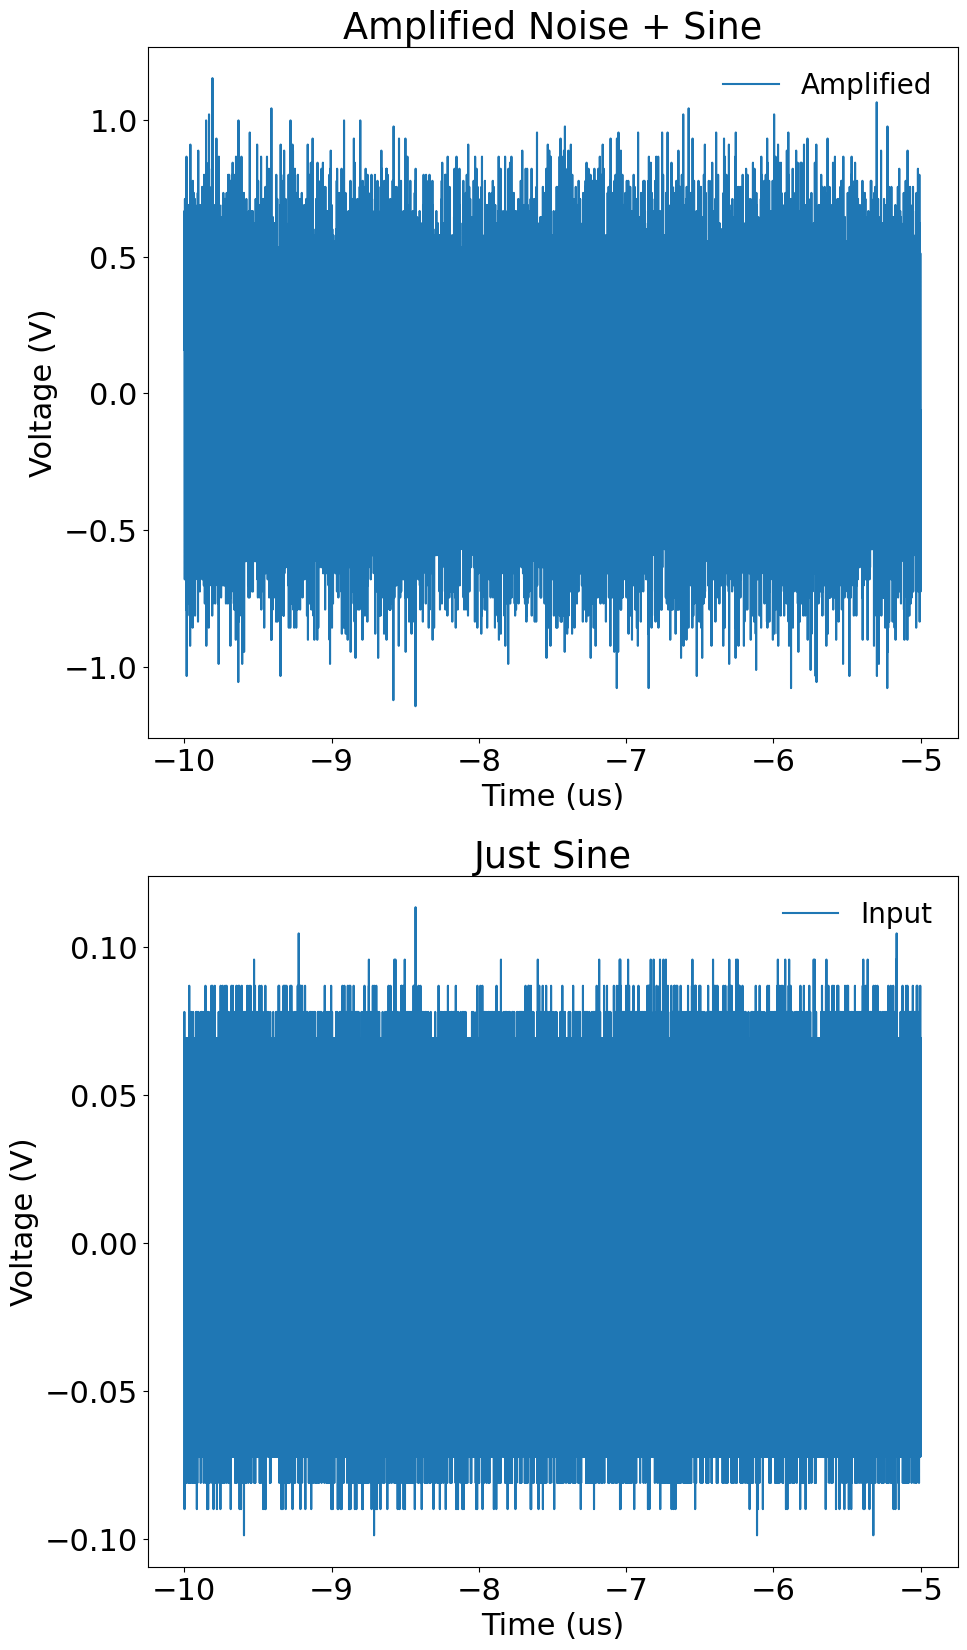

In [3]:
#Plot the raw and smoothed waveforms
fig, ax = plt.subplots(2,1)
ax[0].plot(timeList,noisePlusSineList[0],label="Amplified")
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('Voltage (V)')
ax[0].set_title('Amplified Noise + Sine')    
ax[0].legend(fontsize=20,loc='upper right')


ax[1].plot(timeList,justSineList[0],label="Input")
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('Voltage (V)')
ax[1].set_title('Just Sine')
ax[1].legend(fontsize=20,loc='upper right')
plt.subplots_adjust(bottom=0.1, right=0.8, top=2)

jsRMS=pft.getRMS(justSineList[0])
print("Jist Sine Wave std",np.std(justSineList[0]))
print("Just Sine Wave V RMS",pft.getRMS(justSineList[0]),"V")
print("Just Sine Wave P ",pft.convertPowerTodBm(pft.getRMS(justSineList[0])**2/50),"dBm")

print("Noise Plus Sine Wave V RMS",pft.getRMS(noisePlusSineList[0]),"V")
print("Noise Plus Sine Wave P ",pft.convertPowerTodBm(pft.getRMS(noisePlusSineList[0])**2/50),"dBm")
gainIndB=80
bandwidth=300e6
print("Thermal Noise full band (pre amp):",pft.convertPowerTodBm(pft.getNoiseRMS(292,50,bandwidth)**2/50),"dBm")
print("Thermal Noise full band:",gainIndB+pft.convertPowerTodBm(pft.getNoiseRMS(292,50,bandwidth)**2/50),"dBm")

In [4]:
N=np.shape(noisePlusSineList[0])[0]
dt=timeList[1]-timeList[0]

from scipy.fft import fft, ifft  # Import the fft and inverse fft functions
from scipy.fft import rfft, irfft  # Import the fft and inverse fft functions
yNPS = rfft(noisePlusSineList[0]) #FFT of noise plus sine
yJS = rfft(justSineList[0]) #FFT of just sine
df=1/(N*dt)  # Frequency spacing
#xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)  #The N/2 frequency values from 0 to 1/(2*dt)
xf=pft.getFrequencyBins(N,dt)
print(noisePlusSineList[0].shape)
print(yNPS.shape)




(100000,)
(50001,)


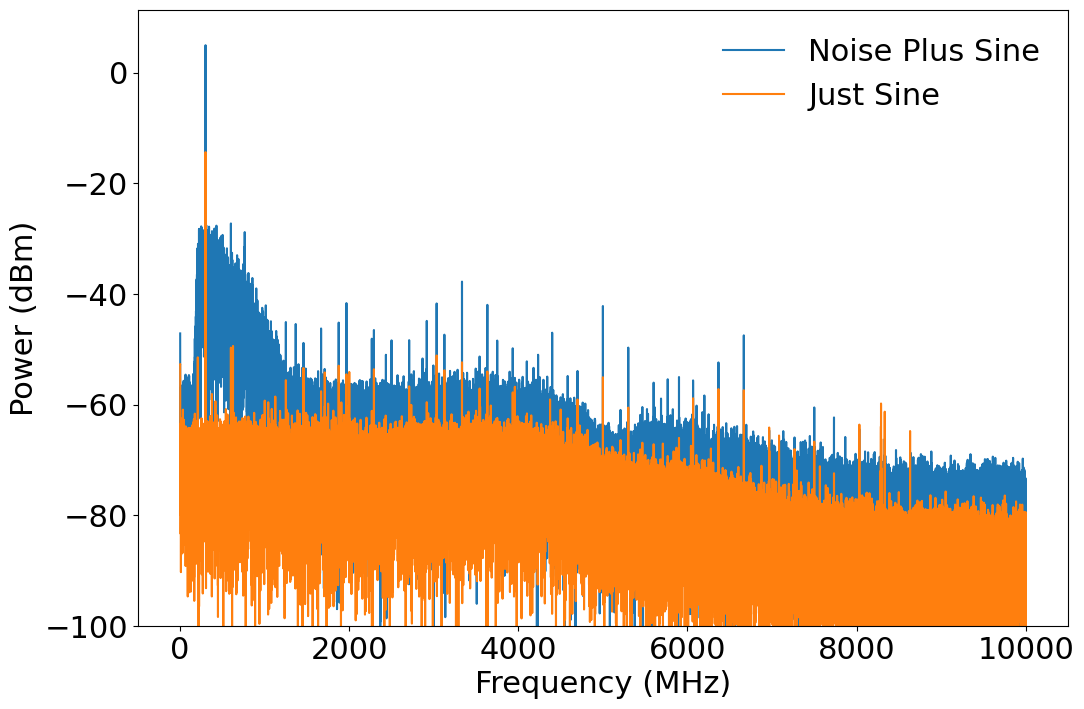

In [5]:
#Plot the frequency around the centre frequency bin
fig,ax = plt.subplots()
ax.plot(xf,pft.convertRFFTTodBm(yNPS),label="Noise Plus Sine") #1e6 to convert to MHz
ax.plot(xf,pft.convertRFFTTodBm(yJS),label="Just Sine")  #1e6 to convert to MHz
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Power (dBm)")
low,high=ax.get_ylim()
ax.set_ylim([-100,high])
ax.legend()

Peak Frequency 299.9999959932382 MHz
Maximum P_JS(dbm): -14.356187172248847 dBm
Maximum P_NS(dbm): 5.066063096426062 dBm
100mV @ 50Ohm -6.9897000433601875 dBm
Just Sine RMS @ 50Ohm -14.05842029510108 dBm


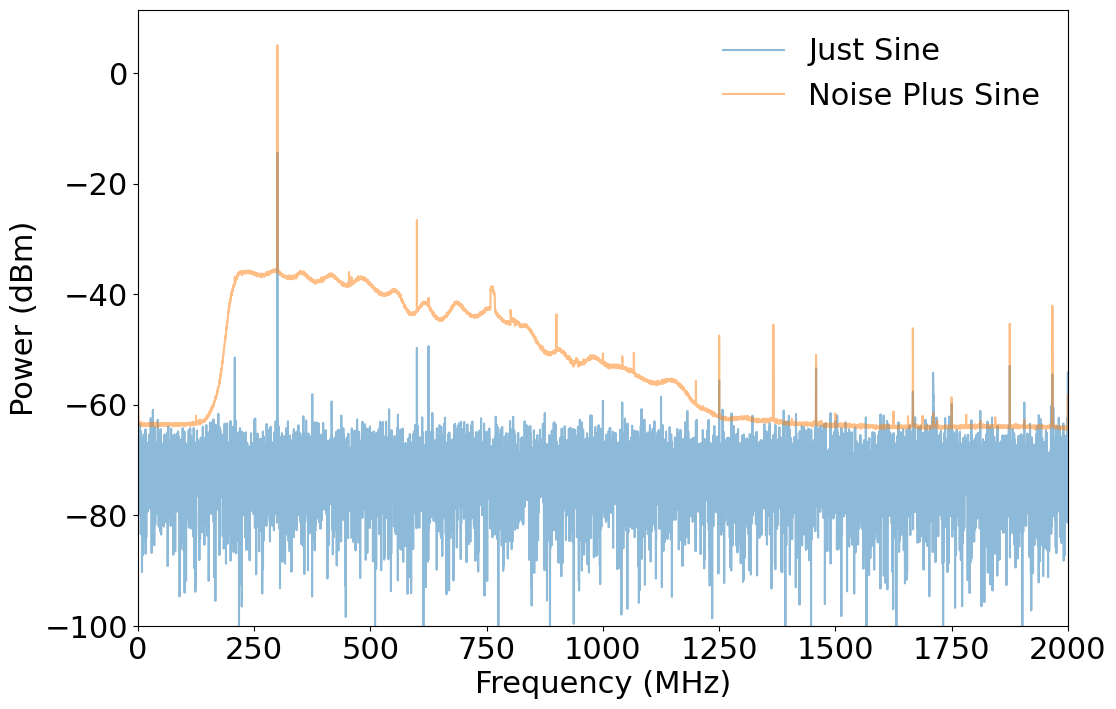

In [6]:
yNPS = rfft(noisePlusSineList) #FFT of noise plus sine
#print(yNPS.shape)

yNPSMean=np.mean(np.abs(yNPS),axis=0)
#print(yNPSMean.shape)

fig,ax = plt.subplots()
ax.plot(xf,pft.convertRFFTTodBm(yJS),label="Just Sine",alpha=0.5)  #1e6 to convert to MHz
ax.plot(xf,pft.convertRFFTTodBm(yNPSMean),label="Noise Plus Sine",alpha=0.5) #1e6 to convert to MHz
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Power (dBm)")
low,high=ax.get_ylim()
ax.set_ylim([-100,high])
ax.set_xlim([0,2e3])
ax.legend()

guessFreq=xf[np.argmax(pft.convertRFFTTodBm(yNPSMean))]
print("Peak Frequency",guessFreq,"MHz")


print("Maximum P_JS(dbm):",np.max(pft.convertRFFTTodBm(yJS)),"dBm")
print("Maximum P_NS(dbm):",np.max(pft.convertRFFTTodBm(yNPSMean)),"dBm")
print("100mV @ 50Ohm",pft.convertVrmsTodBm(0.1),"dBm")
print("Just Sine RMS @ 50Ohm",pft.convertVrmsTodBm(jsRMS),"dBm")


## Simple Sine Wave Fitting Fun


In [7]:
def getSine(t,w,A,phi):
    """Function to return a simple sine 

    Args:
        t: The array of times
        w: The angular frequency
        A: The amplitude
        phi: The phase at t=0
 
     Returns:
        The sine values as an array

    """
    return A*np.sin((w*t)+phi)

def guessFreqFromZeroCrossings(wave,time):
    zero_crossings = np.where(np.diff(np.signbit(wave)))[0]
    return 0.5*zero_crossings.shape[0]/time
    
print(guessFreqFromZeroCrossings(noisePlusSineList[20],(timeList[-2]-timeList[0])))
guessFreq=guessFreqFromZeroCrossings(noisePlusSineList[20],(timeList[-2]-timeList[0]))
guessFreq=300

311.0062159720241


In [8]:
def doSineWaveFit(waveList,guessFreq):
    numWaveforms=waveList.shape[0]
    guessOmega=guessFreq*2*math.pi
    guessAmp=np.max(waveList[0])
    guessPhase=0

    omegas=np.zeros(numWaveforms)
    freqs=np.zeros(numWaveforms)
    amps=np.zeros(numWaveforms)
    phases=np.zeros(numWaveforms)
    failCount=0

    for i in range(numWaveforms):
        try:
            parameters, covariance = curve_fit(getSine, timeList, waveList[i],p0=[guessOmega,guessAmp,guessPhase])
        except:
            print("Failure ",failCount," to fit",i)
            failCount=failCount+1
            if(failCount>10):
                raise Exception("Sorry I've given up after failing to fit",failCount)
        omegas[i]=parameters[0]
        freqs[i]=parameters[0]/(2*math.pi)
        amps[i]=parameters[1]
        phases[i]=parameters[2]
    return omegas,freqs,amps,phases

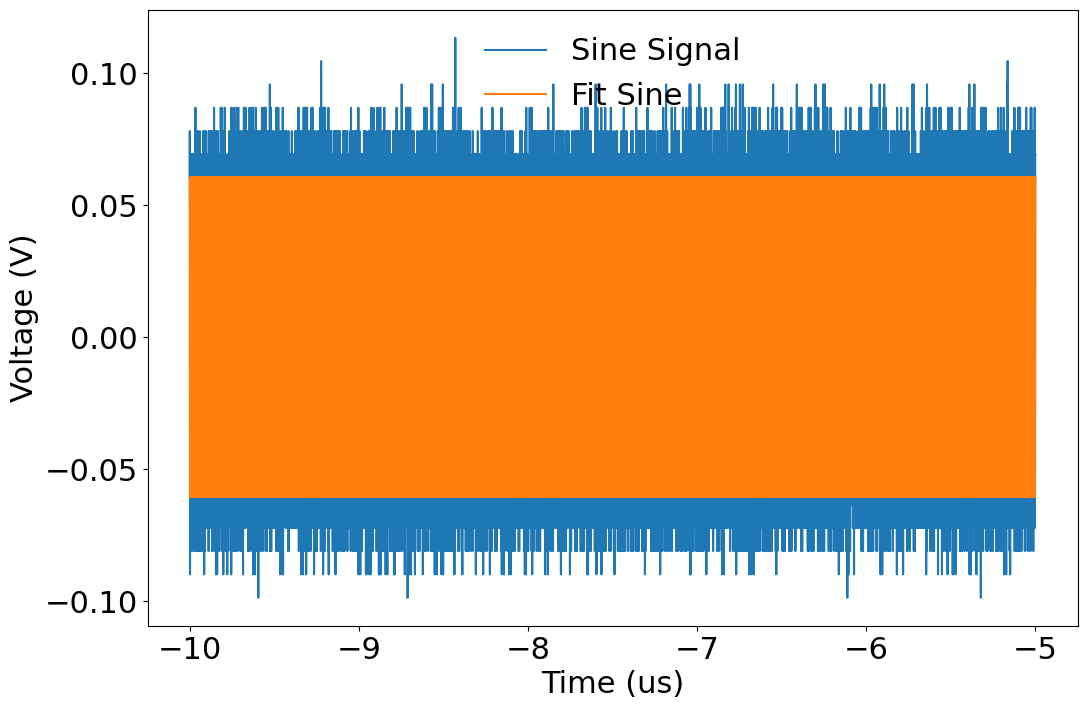

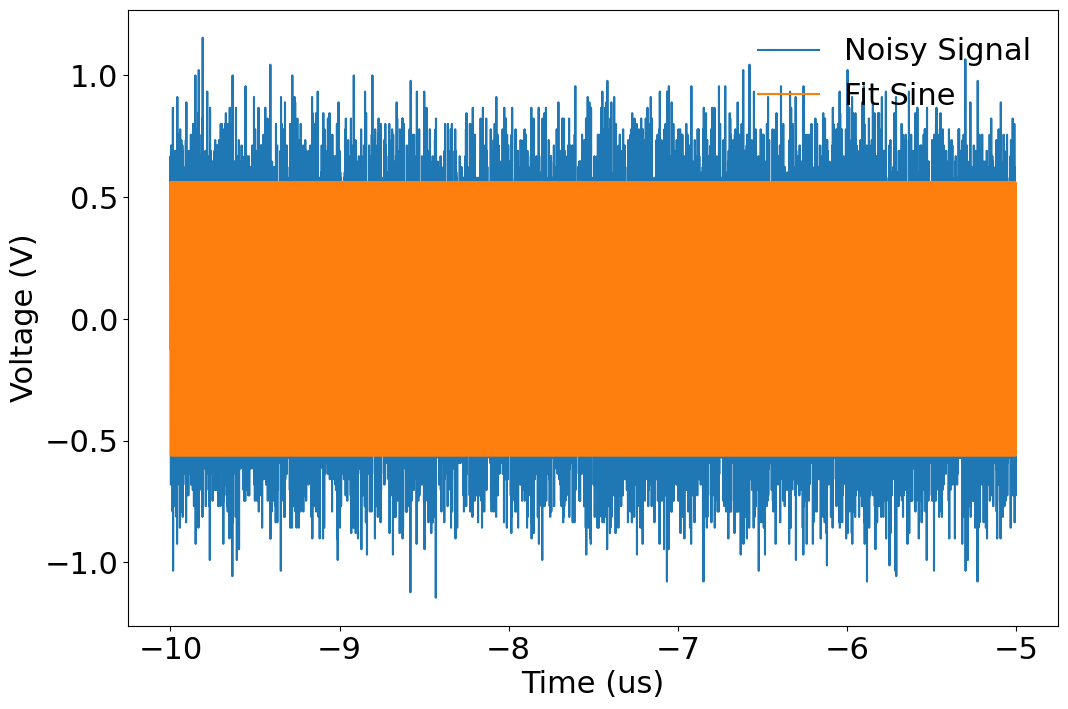

In [9]:
jsOmega,jsFreq,jsAmp,jsPhase=doSineWaveFit(justSineList,guessFreq)
npsOmega,npsFreq,npsAmp,npsPhase=doSineWaveFit(noisePlusSineList,guessFreq)


fig,ax = plt.subplots()
#ax.hist(amps,alpha=0.5,label="Sine 50MHz")
#ax.set_xlabel("Fit Frequency (Hz)")
#ax.set_ylabel("#Events")
#ax.legend()
#print("Freq std",np.std(freqs))
ax.plot(timeList,justSineList[0],label="Sine Signal")
ax.plot(timeList,getSine(timeList,jsOmega[0],jsAmp[0],jsPhase[0]),label="Fit Sine")
ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
ax.legend()

fig,ax = plt.subplots()
#ax.hist(amps,alpha=0.5,label="Sine 50MHz")
#ax.set_xlabel("Fit Frequency (Hz)")
#ax.set_ylabel("#Events")
#ax.legend()
#print("Freq std",np.std(freqs))
ax.plot(timeList,noisePlusSineList[0],label="Noisy Signal")
ax.plot(timeList,getSine(timeList,npsOmega[0],npsAmp[0],npsPhase[0]),label="Fit Sine")
ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
ax.legend()



0.43401728700845604 0.4305996035071291


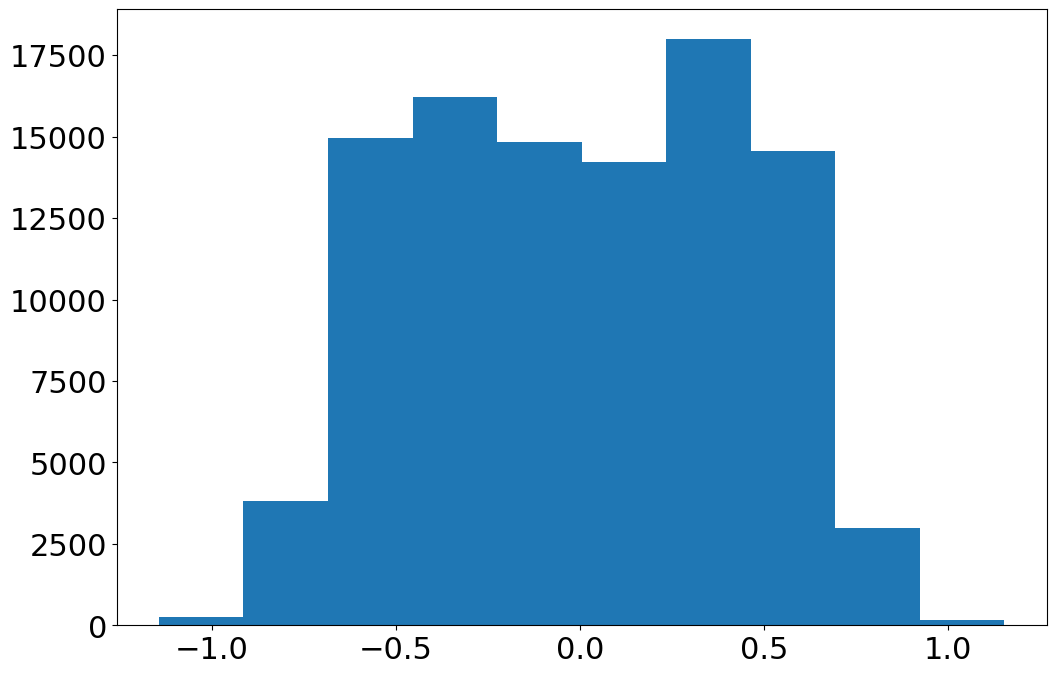

In [10]:
fig,ax = plt.subplots()
ax.hist(noisePlusSineList[0])
print(np.std(noisePlusSineList),pft.getRMS(noisePlusSineList[0]))

Clean Freq std 0.00013018943278724336 MHz
Noisy Freq std 0.0007974123112774697 MHz
Clean Mean Amp -0.016115044269819592 V -3.2230088539639184e-05
Noisy Mean Amp 0.5666547073968868 V 0.0011333094147937736


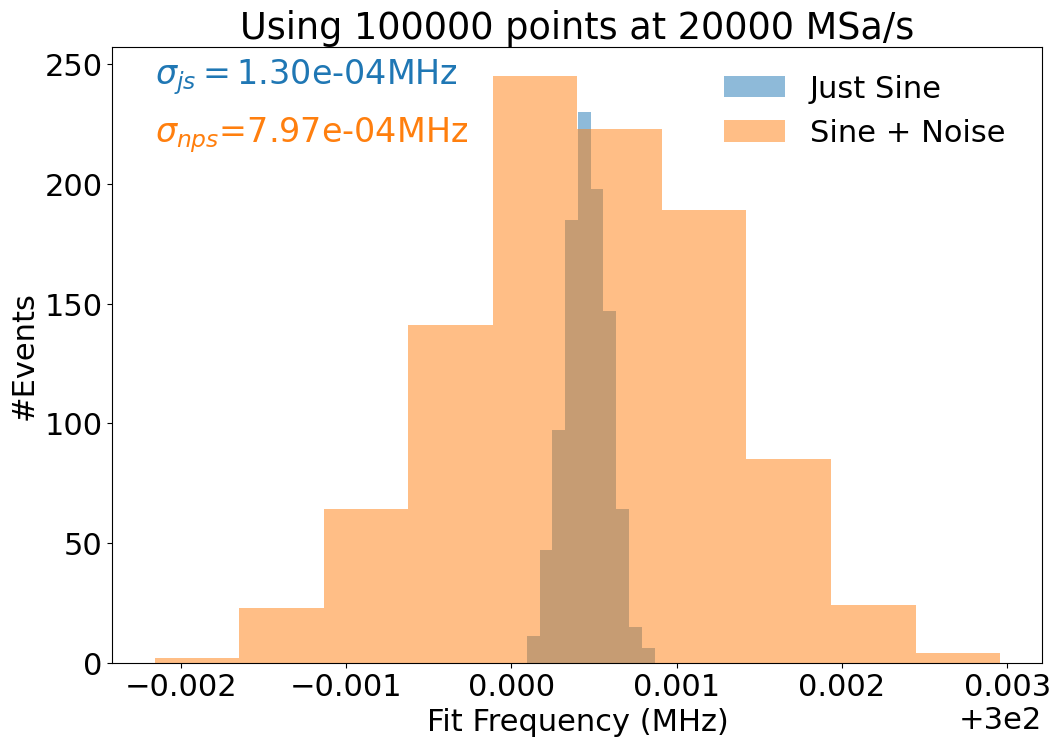

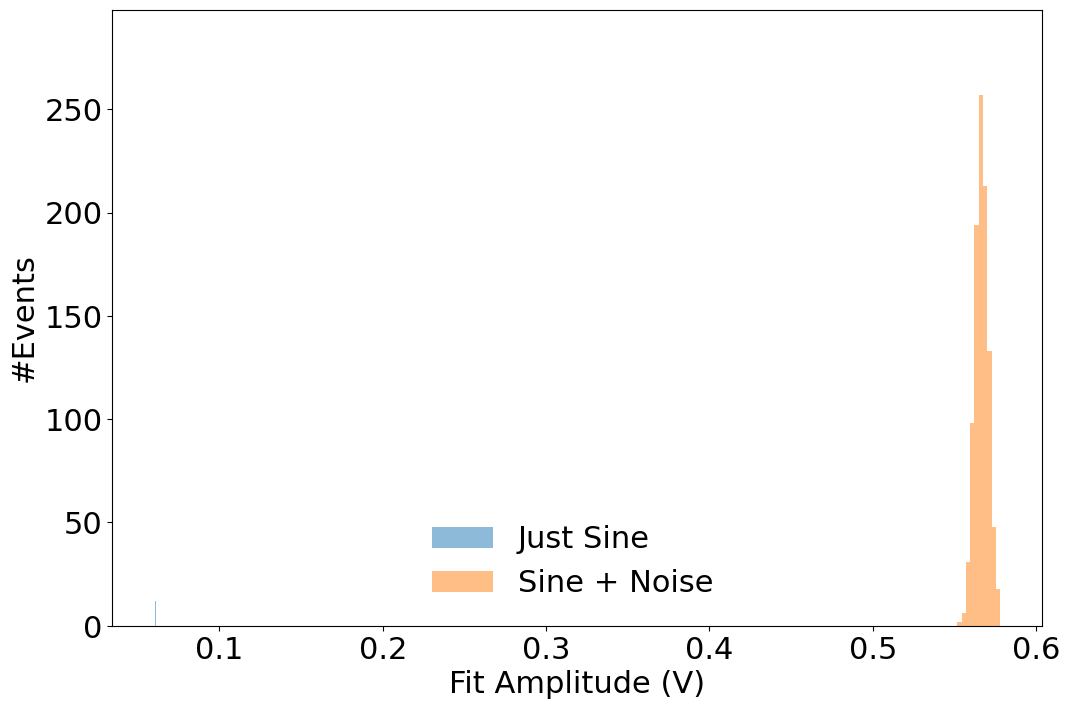

In [11]:
fig,ax = plt.subplots()
counts,_,_ = ax.hist(jsFreq,alpha=0.5,label="Just Sine")
counts2,bins,_ =ax.hist(npsFreq,alpha=0.5,label="Sine + Noise ")
ax.set_xlabel("Fit Frequency (MHz)")
ax.set_ylabel("#Events")
ax.legend()
ax.set_title("Using "+str(N)+" points at "+str(int(np.round(fs,0)))+" MSa/s")

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

text_kwargs = dict(ha='left', va='center', fontsize=24, color=colors[0])
stdLabel=r"$\sigma_{js}=$%2.2eMHz" % (np.std(jsFreq))
ax.text(bins[0],np.max([counts,counts2]),stdLabel,**text_kwargs )
text_kwargs = dict(ha='left', va='center', fontsize=24, color=colors[1])
stdLabel=r"$\sigma_{nps}$=%2.2eMHz" % (np.std(npsFreq))
ax.text(bins[0],0.9*np.max([counts,counts2]),stdLabel,**text_kwargs )
print("Clean Freq std",np.std(jsFreq),"MHz")
print("Noisy Freq std",np.std(npsFreq),"MHz")

fig,ax = plt.subplots()
ax.hist(np.abs(jsAmp),alpha=0.5,label="Just Sine")
ax.hist(np.abs(npsAmp),alpha=0.5,label="Sine + Noise ")
ax.set_xlabel("Fit Amplitude (V)")
ax.set_ylabel("#Events")
ax.legend()
print("Clean Mean Amp",np.mean(jsAmp),"V",np.mean(jsAmp)/500)
print("Noisy Mean Amp",np.mean(npsAmp),"V",np.mean(npsAmp)/500)



In [12]:
T=(timeList[-1]-timeList[0])*1e-6
deltaf=1/T
print(T,deltaf)

4.999950066756493e-06 200001.9973496871


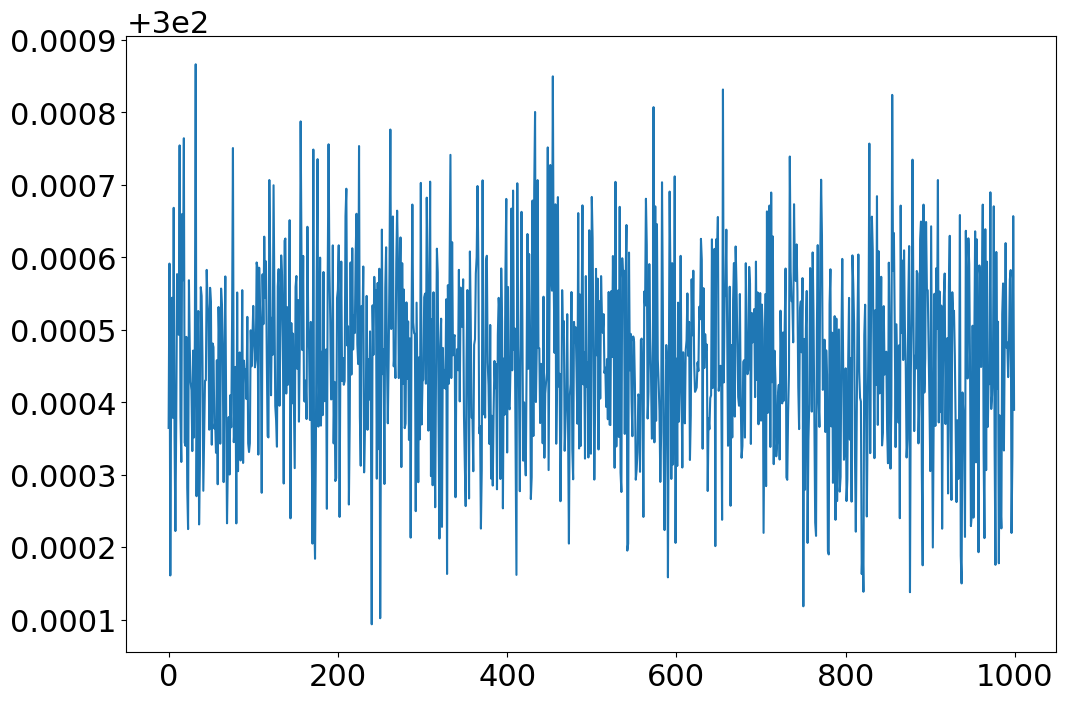

In [13]:
fig,ax = plt.subplots()
eventNum=np.arange(jsFreq.shape[0])
ax.plot(eventNum,jsFreq)

19.999999732882547 4999.9500667564935 2.4999250674940544e-06 2.4999750667675953e-16


Text(0, 0.5, 'Frequency Resolution (Hz)')

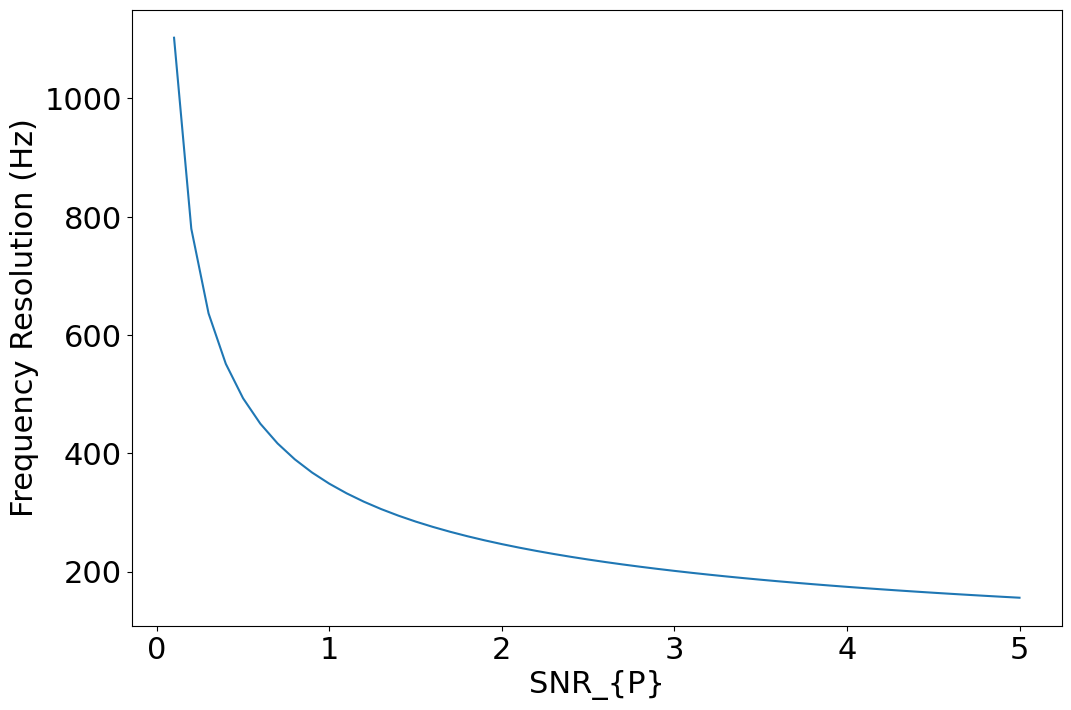

In [14]:
R=fs
T=timeList[-1]-timeList[0]

#Convert to Hz,s
R=1e6*R
T=1e-6*T


def getEstFreqVariance(snrp,samplingRate,observationTime):
    return 3 / (math.pi**2 *(snrp*(samplingRate*observationTime**3 - observationTime/samplingRate)))

print(R/1e9,T*1e9, R*(T**3),T/R)

snrpArr=np.linspace(0.1,5,50)
fig,ax = plt.subplots()
ax.plot(snrpArr,np.sqrt(getEstFreqVariance(snrpArr,R,T)))
ax.set_xlabel("SNR_{P}")
ax.set_ylabel("Frequency Resolution (Hz)")
